In [57]:
from load_data import load_breast_cancer_data, load_wine_quality_data

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_mutual_info_score
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

import time

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data loading and preprocessing

In [58]:
# Read data
X1, y1 = load_breast_cancer_data('../data/breast-cancer-wisconsin-data/data.csv')
# X2, y2 = load_wine_quality_data('../data/wine-quality/winequality-white.csv')

# Print information about the datasets
print ("<------------------------ Breast Cancer Dataset ------------------------>")
print ("Total number of examples: ", X1.shape[0])
print ("Fraction of positive examples: %.2f%%" % (y1[y1 == 1].shape[0]/y1.shape[0]*100.0))
print ("Number of features: ", X1.shape[1])
print()
# print ("<------------------------ Wine Quality Dataset ------------------------>")
# print ("Total number of examples: ", X2.shape[0])
# print ("Fraction of positive examples: %.2f%%" % (y2[y2 == 1].shape[0]/y2.shape[0]*100.0))
# print ("Number of features: ", X2.shape[1])
# print()

# Random seed for reproducibility of experiments
random_seed = 7641
np.random.seed(random_seed)

# Standardize data
X1 = preprocessing.scale(X1)
# X2 = preprocessing.scale(X2)

# Split into training and test data. Use random_state to get the same results in every run
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.4, random_state=18)
# X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.4, random_state=18)

<------------------------ Breast Cancer Dataset ------------------------>
Total number of examples:  569
Fraction of positive examples: 37.26%
Number of features:  30



# Training a neural network without dimensionality reduction

In [80]:
clf_nn = MLPClassifier(hidden_layer_sizes=(5, 2), random_state=7, max_iter=1000)
clf_nn.fit(X_train, y_train)
y_pred = clf_nn.predict(X_test)
nn_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy of neural network without hyperparameter tuning is %.2f%%' % (nn_accuracy * 100))

Accuracy of neural network without hyperparameter tuning is 96.49%


## Hyperparameter tuning

In [81]:
# Define grid for grid search after observing validation curves
alpha_range = np.logspace(-1, 2, 5)
lr_range = np.logspace(-5, 0, 6)
tuned_params = {'alpha' : alpha_range, 'learning_rate_init' : lr_range}
clf_nn = GridSearchCV(clf_nn, param_grid=tuned_params, cv=5, n_jobs=-1)
clf_nn.fit(X_train_pca, y_train)
best_clf_nn = clf_nn.best_estimator_
best_params = clf_nn.best_params_
print("Best parameters set found on development set:")
print(best_params)

Best parameters set found on development set:
{'alpha': 0.5623413251903491, 'learning_rate_init': 0.01}


## Evaluate optimal model

In [82]:
t0 = time.time()
best_clf_nn.fit(X_train, y_train)
t1 = time.time()
print('Training time: %f seconds' % (t1 - t0))
t0 = time.time()
y_pred = best_clf_nn.predict(X_test)
t1 = time.time()
test_time = t1 - t0
print('Inference time on test data: %f seconds' % test_time)
best_accuracy = accuracy_score(y_test, y_pred)
print('Best accuracy of neural network is %.2f%%' % (best_accuracy * 100))

Training time: 0.154904 seconds
Inference time on test data: 0.000999 seconds
Best accuracy of neural network is 97.81%


# PCA

In [62]:
pca = PCA()
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

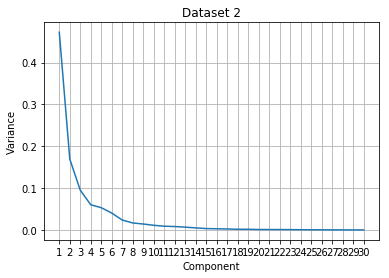

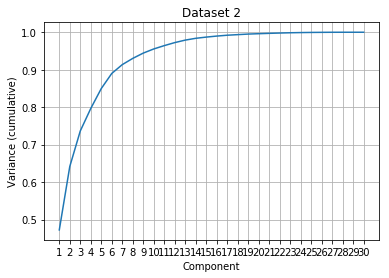

In [63]:
# Plot variance explained by each component to find the best number of components
plt.figure()
plt.plot(np.arange(1, pca.explained_variance_ratio_.size + 1), pca.explained_variance_ratio_)
plt.xticks(np.arange(1, pca.explained_variance_ratio_.size + 1))
plt.xlabel('Component')
plt.ylabel('Variance')
plt.title('Dataset 2')
plt.grid()
plt.savefig('../plots/nn_pca_var_2.png')

plt.figure()
plt.plot(np.arange(1, pca.explained_variance_ratio_.size + 1), np.cumsum(pca.explained_variance_ratio_))
plt.xticks(np.arange(1, pca.explained_variance_ratio_.size + 1))
plt.xlabel('Component')
plt.ylabel('Variance (cumulative)')
plt.title('Dataset 2')
plt.grid()
plt.savefig('../plots/nn_pca_var_cum_2.png')

In [64]:
# Choose the number of components that capture 85% of the variance
num_components = 6

# Transform the data
pca = PCA(n_components=num_components)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

# Neural network classification on projected data

In [65]:
clf_nn = MLPClassifier(hidden_layer_sizes=(5, 2), random_state=7, max_iter=1000)
clf_nn.fit(X_train_pca, y_train)
y_pred = clf_nn.predict(X_test_pca)
nn_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy of neural network without hyperparameter tuning is %.2f%%' % (nn_accuracy * 100))

Accuracy of neural network without hyperparameter tuning is 97.37%


## Hyperparameter tuning

In [66]:
# Define grid for grid search after observing validation curves
alpha_range = np.logspace(-1, 2, 5)
lr_range = np.logspace(-5, 0, 6)
tuned_params = {'alpha' : alpha_range, 'learning_rate_init' : lr_range}
clf_nn = GridSearchCV(clf_nn, param_grid=tuned_params, cv=5, n_jobs=-1)
clf_nn.fit(X_train_pca, y_train)
best_clf_nn = clf_nn.best_estimator_
best_params = clf_nn.best_params_
print("Best parameters set found on development set:")
print(best_params)

Best parameters set found on development set:
{'alpha': 0.5623413251903491, 'learning_rate_init': 0.01}


## Evaluate optimal model

In [67]:
t0 = time.time()
best_clf_nn.fit(X_train_pca, y_train)
t1 = time.time()
print('Training time: %f seconds' % (t1 - t0))
t0 = time.time()
y_pred = best_clf_nn.predict(X_test_pca)
t1 = time.time()
test_time = t1 - t0
print('Inference time on test data: %f seconds' % test_time)
best_accuracy = accuracy_score(y_test, y_pred)
print('Best accuracy of neural network is %.2f%%' % (best_accuracy * 100))

Training time: 0.322799 seconds
Inference time on test data: 0.000000 seconds
Best accuracy of neural network is 97.81%


# K-means

In [68]:
kmeans = KMeans(n_clusters=num_components, random_state=random_seed, n_jobs=-1)
kmeans.fit(X_train)
X_train_kmeans = kmeans.transform(X_train)
X_test_kmeans = kmeans.transform(X_test)

# Neural network classification on projected data

In [69]:
clf_nn = MLPClassifier(hidden_layer_sizes=(5, 2), random_state=7, max_iter=1000)
clf_nn.fit(X_train_kmeans, y_train)
y_pred = clf_nn.predict(X_test_kmeans)
nn_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy of neural network without hyperparameter tuning is %.2f%%' % (nn_accuracy * 100))

Accuracy of neural network without hyperparameter tuning is 95.61%


## Hyperparameter tuning

In [70]:
# Define grid for grid search after observing validation curves
alpha_range = np.logspace(-1, 2, 5)
lr_range = np.logspace(-5, 0, 6)
tuned_params = {'alpha' : alpha_range, 'learning_rate_init' : lr_range}
clf_nn = GridSearchCV(clf_nn, param_grid=tuned_params, cv=5, n_jobs=-1)
clf_nn.fit(X_train_kmeans, y_train)
best_clf_nn = clf_nn.best_estimator_
best_params = clf_nn.best_params_
print("Best parameters set found on development set:")
print(best_params)

Best parameters set found on development set:
{'alpha': 0.5623413251903491, 'learning_rate_init': 0.001}


## Evaluate optimal model

In [71]:
t0 = time.time()
best_clf_nn.fit(X_train_kmeans, y_train)
t1 = time.time()
print('Training time: %f seconds' % (t1 - t0))
t0 = time.time()
y_pred = best_clf_nn.predict(X_test_kmeans)
t1 = time.time()
test_time = t1 - t0
print('Inference time on test data: %f seconds' % test_time)
best_accuracy = accuracy_score(y_test, y_pred)
print('Best accuracy of neural network is %.2f%%' % (best_accuracy * 100))

Training time: 0.389758 seconds
Inference time on test data: 0.000000 seconds
Best accuracy of neural network is 96.05%


# GMM-EM

In [83]:
gmm = GaussianMixture(n_components=num_components, random_state=random_seed)
gmm.fit(X_train)
X_train_gmm = gmm.predict_proba(X_train)
X_test_gmm = gmm.predict_proba(X_test)

# Neural network classification on projected data

In [94]:
clf_nn = MLPClassifier(hidden_layer_sizes=(5, 2), random_state=7, max_iter=1000)
clf_nn.fit(X_train_gmm, y_train)
y_pred = clf_nn.predict(X_test_gmm)
nn_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy of neural network without hyperparameter tuning is %.2f%%' % (nn_accuracy * 100))

Accuracy of neural network without hyperparameter tuning is 89.91%


## Hyperparameter tuning

In [95]:
# Define grid for grid search after observing validation curves
# alpha_range = np.logspace(-10, -5, 5)
alpha_range = np.asarray([0])
lr_range = np.logspace(-5, 0, 6)
tuned_params = {'alpha' : alpha_range, 'learning_rate_init' : lr_range}
clf_nn = GridSearchCV(clf_nn, param_grid=tuned_params, cv=5, n_jobs=-1)
clf_nn.fit(X_train_gmm, y_train)
best_clf_nn = clf_nn.best_estimator_
best_params = clf_nn.best_params_
print("Best parameters set found on development set:")
print(best_params)

Best parameters set found on development set:
{'alpha': 0, 'learning_rate_init': 0.0001}


C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


## Evaluate optimal model

In [96]:
t0 = time.time()
best_clf_nn.fit(X_train_gmm, y_train)
t1 = time.time()
print('Training time: %f seconds' % (t1 - t0))
t0 = time.time()
y_pred = best_clf_nn.predict(X_test_gmm)
t1 = time.time()
test_time = t1 - t0
print('Inference time on test data: %f seconds' % test_time)
best_accuracy = accuracy_score(y_test, y_pred)
print('Best accuracy of neural network is %.2f%%' % (best_accuracy * 100))

Training time: 1.241231 seconds
Inference time on test data: 0.000000 seconds
Best accuracy of neural network is 90.35%


C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
